In [1]:
from nearest_neighbors import KNNClassifier
from cross_validation import kfold, knn_cross_val_score

In [2]:
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
import time
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

%matplotlib inline

%config InlineBackend.figure_format = 'svg'

In [4]:
mnist = fetch_openml("mnist_784")

In [5]:
X, y = mnist.data.to_numpy(), mnist.target.astype('int').to_numpy()

In [6]:
X.shape

(70000, 784)

In [7]:
X_train = X[:60000]
y_train = y[:60000]

In [8]:
X_test = X[60000:]
y_test = y[60000:]

In [9]:
timings = pd.DataFrame({'time(seconds)':[], 'features number':[], 'algorithm':[]})

In [10]:
for n_features in (10, 20, 100):
    features = np.sort(np.random.choice(range(784), size=n_features, replace=False))
    train = X_train[:, features]
    test = X_test[:, features]
    for strategy in ('kd_tree', 'ball_tree', 'brute', 'my_own'):
        knn = KNNClassifier(k=5, strategy=strategy, metric='euclidean', weights=False)
        knn.fit(train, y_train)
        start = time.time()
        knn.find_kneighbors(test, False)
        end = time.time()
        timings = timings._append({'time(seconds)':(end-start) * 10, 'features number':n_features, 'algorithm':strategy}, ignore_index = True)

In [11]:
timings

,time(seconds),features number,algorithm
0,32.931993,10.0,kd_tree
1,44.953790,10.0,ball_tree
2,7.230246,10.0,brute
3,95.292225,10.0,my_own
4,69.571526,20.0,kd_tree
5,154.889529,20.0,ball_tree
6,3.671470,20.0,brute
7,95.333843,20.0,my_own
8,829.234681,100.0,kd_tree
9,707.483966,100.0,ball_tree


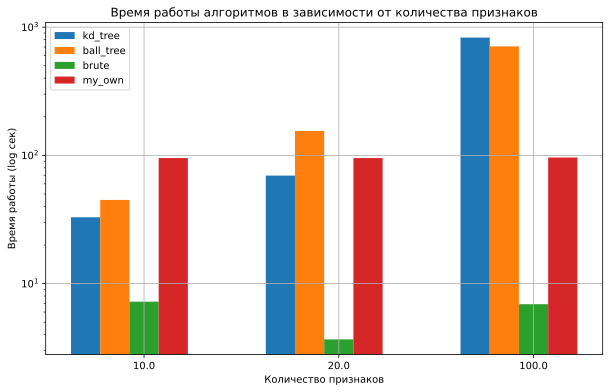

In [12]:
df = timings
algorithms = df['algorithm'].unique()
features = df['features number'].unique()
width = 0.15
x = np.arange(len(features), dtype=int)
plt.figure(figsize=(10, 6))
for i, alg in enumerate(['kd_tree', 'ball_tree', 'brute', 'my_own']):
    plt.bar(x + i*width - width*(len(algorithms)/2), df.loc[df['algorithm'] == alg, 'time(seconds)'], width, label=alg)
plt.xlabel('Количество признаков')
plt.ylabel('Время работы (log сек)')
plt.title('Время работы алгоритмов в зависимости от количества признаков')
plt.xticks(x, features)
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.savefig('alg_feature.pdf', format='pdf')
plt.show()

Метрика: euclidean, время выполнения: 30.540650 секунд
Метрика: cosine, время выполнения: 69.960669 секунд


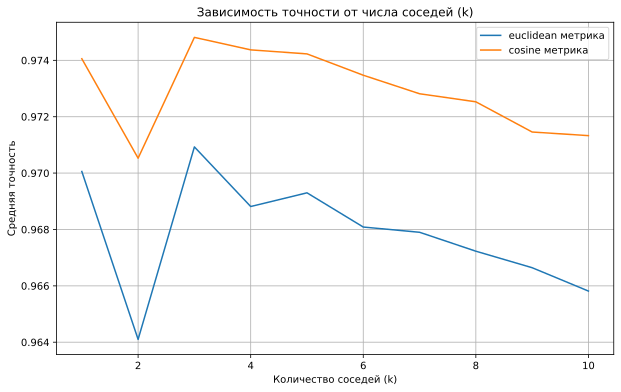

In [13]:
res = {}
k_values = list(range(1, 11))
for metric in ('euclidean', 'cosine'):
    start_time = time.time()
    scores = knn_cross_val_score(X, y, k_values, 'accuracy', cv=kfold(len(y), 3), metric=metric, strategy='brute', weights=False)
    end_time = time.time()
    avg_scores = {k: np.mean(scores[k]) for k in k_values}
    res[metric] = avg_scores
    print(f"Метрика: {metric}, время выполнения: {end_time - start_time:.6f} секунд")
plt.figure(figsize=(10, 6))
for metric, avg_scores in res.items():
    plt.plot(k_values, list(avg_scores.values()), label=f'{metric} метрика')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Средняя точность')
plt.title('Зависимость точности от числа соседей (k)')
plt.legend()
plt.grid(True)
plt.savefig('metric_k.pdf', format='pdf')
plt.show()

Метрика: euclidean, веса: True, время выполнения: 24.149072 секунд
Метрика: euclidean, веса: False, время выполнения: 23.085120 секунд


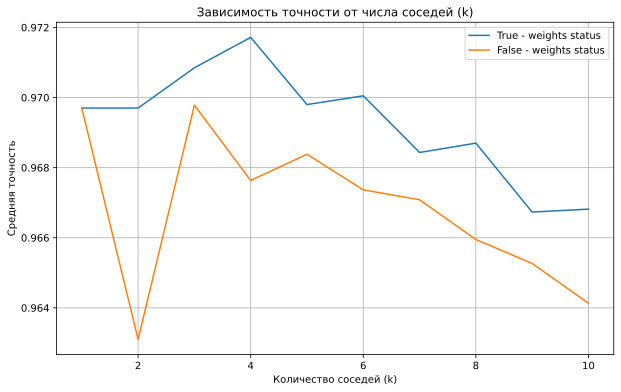

Метрика: cosine, веса: True, время выполнения: 48.408618 секунд
Метрика: cosine, веса: False, время выполнения: 47.752482 секунд


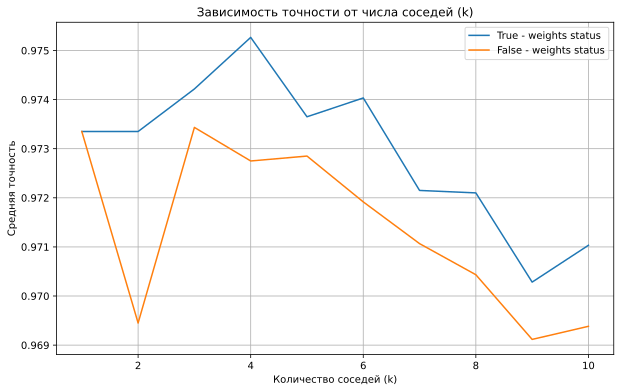

In [14]:
k_values = list(range(1, 11))
cv = kfold(len(y_train), 3)
for metric in ('euclidean', 'cosine'):
    res = {}
    for weights in (True, False):
        start_time = time.time()
        scores = knn_cross_val_score(X_train, y_train, k_values, 'accuracy', cv=cv, metric=metric, strategy='brute', weights=weights)
        end_time = time.time()
        avg_scores = {k: np.mean(scores[k]) for k in k_values}
        res[weights] = avg_scores
        print(f"Метрика: {metric}, веса: {weights}, время выполнения: {end_time - start_time:.6f} секунд")
    plt.figure(figsize=(10, 6))
    for weights, avg_scores in res.items():
        plt.plot(k_values, list(avg_scores.values()), label=f'{weights} - weights status')
    plt.xlabel('Количество соседей (k)')
    plt.ylabel('Средняя точность')
    plt.title('Зависимость точности от числа соседей (k)')
    plt.legend()
    plt.grid(True)
    plt.savefig(metric+"_weights_"+str(weights)+".pdf", format='pdf')
    plt.show()

In [15]:
#k=4, weights=True

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [17]:
def print_condusion_matrix(y_test, y_pred, name):
    conf_matr = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 6))
    plt.imshow(conf_matr, interpolation='nearest', cmap="Greys")
    plt.title('Матрица ошибок')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test))
    plt.yticks(tick_marks, np.unique(y_test))
    plt.xlabel("Предсказанный класс")
    plt.ylabel("Истинный класс")
    for i, j in np.ndindex(conf_matr.shape):
        plt.text(j, i, format(conf_matr[i, j], 'd'), horizontalalignment="center",
                 color="white" if conf_matr[i, j] > conf_matr.max() / 2 else "black")
    plt.tight_layout()
    plt.savefig(name+'.pdf', format='pdf')
    plt.show()

Точность на тестовой выборке: 0.975200
Точность по кросс-валидации: 0.976657


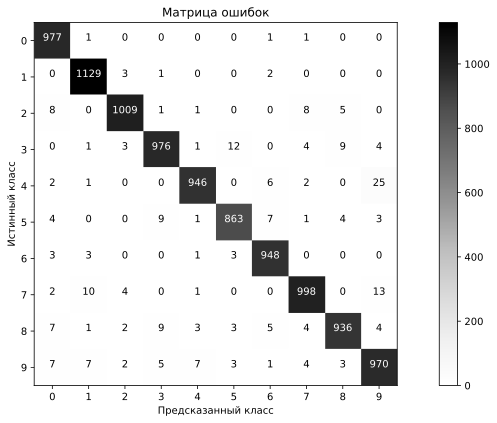

In [18]:
best_knn = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке: {test_accuracy:.6f}")
cv_accuracy = np.mean(knn_cross_val_score(X, y, k_list=[4], score='accuracy', cv=kfold(len(y), 3), metric='cosine', strategy='brute', weights=True)[4])
print(f"Точность по кросс-валидации: {cv_accuracy:.6f}")
print_condusion_matrix(y_test, y_pred, 'best_model')

<Figure size 1200x800 with 0 Axes>

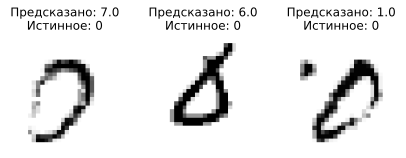

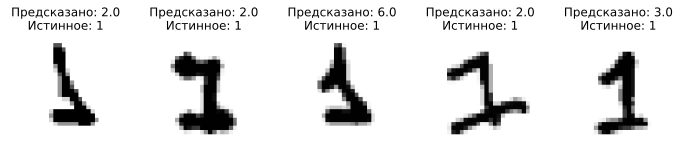

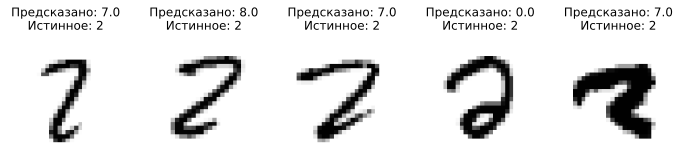

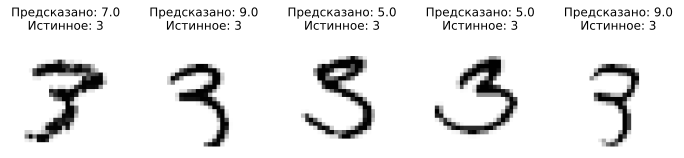

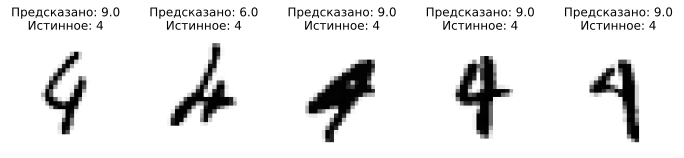

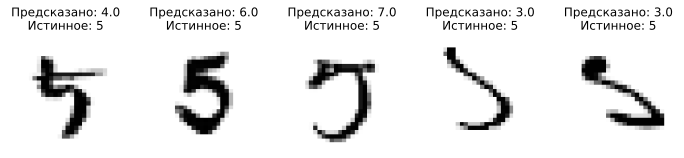

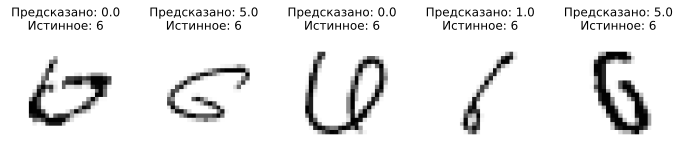

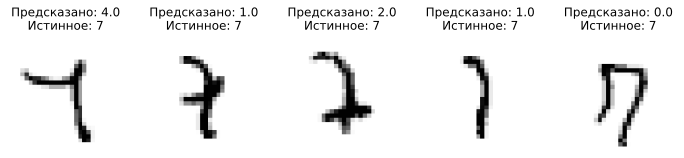

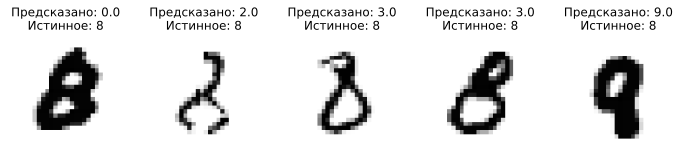

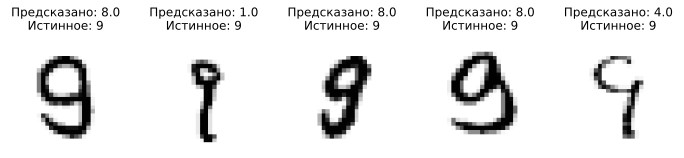

Количество ошибок: 248


In [19]:
errors = np.where(y_test != y_pred)[0]
num_errors_to_visualize = min(5, len(errors))
plt.figure(figsize=(12, 8))
for num in range(10):
    error_nums = errors[np.where(y_test[errors] == num)]
    plt.figure(figsize=(12, 8))
    for i, error_index in enumerate(error_nums[:num_errors_to_visualize]):
        plt.subplot(1, num_errors_to_visualize, i+1)
        plt.imshow(X_test[error_index].reshape(28, 28), cmap="Greys")
        plt.title(f"Предсказано: {y_pred[error_index]}\nИстинное: {y_test[error_index]}")
        plt.axis("off")
    plt.savefig('error_'+str(num)+'.pdf', format='pdf')
    plt.show()
print(f"Количество ошибок: {len(errors)}")

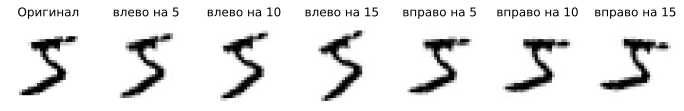

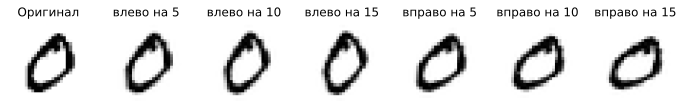

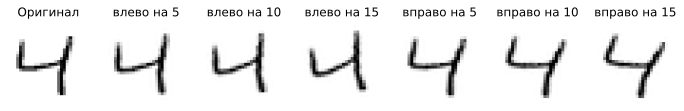

In [20]:
from scipy.ndimage import rotate
i = 0
X_rot_plus_5 = []
X_rot_plus_10 = []
X_rot_plus_15 = []
X_rot_minus_5 = []
X_rot_minus_10 = []
X_rot_minus_15 = []
for row in X_train:
    image = row.reshape(28, 28).astype(np.uint8)
    rotated_image_p5 = rotate(image, angle=5, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    rotated_image_p10 = rotate(image, angle=10, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    rotated_image_p15 = rotate(image, angle=15, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    rotated_image_m5 = rotate(image, angle=-5, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    rotated_image_m10 = rotate(image, angle=-10, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    rotated_image_m15 = rotate(image, angle=-15, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    X_rot_plus_5.append(np.array(rotated_image_p5).reshape(-1).astype(float))
    X_rot_plus_10.append(np.array(rotated_image_p10).reshape(-1).astype(float))
    X_rot_plus_15.append(np.array(rotated_image_p15).reshape(-1).astype(float))
    X_rot_minus_5.append(np.array(rotated_image_m5).reshape(-1).astype(float))
    X_rot_minus_10.append(np.array(rotated_image_m10).reshape(-1).astype(float))
    X_rot_minus_15.append(np.array(rotated_image_m15).reshape(-1).astype(float))
    if (i < 3):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 7, 1)
        plt.imshow(image, cmap='Greys')
        plt.title('Оригинал')
        plt.axis('off')
        plt.subplot(1, 7, 2)
        plt.imshow(rotated_image_p5, cmap='Greys')
        plt.title('влево на 5')
        plt.axis('off')
        plt.subplot(1, 7, 3)
        plt.imshow(rotated_image_p10, cmap='Greys')
        plt.title('влево на 10')
        plt.axis('off')
        plt.subplot(1, 7, 4)
        plt.imshow(rotated_image_p15, cmap='Greys')
        plt.title('влево на 15')
        plt.axis('off')
        plt.subplot(1, 7, 5)
        plt.imshow(rotated_image_m5, cmap='Greys')
        plt.title('вправо на 5')
        plt.axis('off')
        plt.subplot(1, 7, 6)
        plt.imshow(rotated_image_m10, cmap='Greys')
        plt.title('вправо на 10')
        plt.axis('off')
        plt.subplot(1, 7, 7)
        plt.imshow(rotated_image_m15, cmap='Greys')
        plt.title('вправо на 15')
        plt.axis('off')
        plt.savefig('rotation_exmpl_'+str(i)+'.pdf', format='pdf')
        plt.show()
    i += 1
X_rot_plus_5 = np.array(X_rot_plus_5)
X_rot_plus_10 = np.array(X_rot_plus_10)
X_rot_plus_15 = np.array(X_rot_plus_15)
X_rot_minus_5 = np.array(X_rot_minus_5)
X_rot_minus_10 = np.array(X_rot_minus_10)
X_rot_minus_15 = np.array(X_rot_minus_15)

In [21]:
scores = {}
cv = kfold(len(y_train), 3)
scores['+10'] = np.mean(knn_cross_val_score(X_rot_plus_10, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['+15'] = np.mean(knn_cross_val_score(X_rot_plus_15, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['+5'] = np.mean(knn_cross_val_score(X_rot_plus_5, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['-10'] = np.mean(knn_cross_val_score(X_rot_minus_10, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['-15'] = np.mean(knn_cross_val_score(X_rot_minus_15, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['-5'] = np.mean(knn_cross_val_score(X_rot_minus_5, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])

In [22]:
scores

{'+10': 0.9765,
 '+15': 0.9765333333333333,
 '+5': 0.9766333333333334,
 '-10': 0.9764499999999999,
 '-15': 0.9763166666666666,
 '-5': 0.9767833333333334}

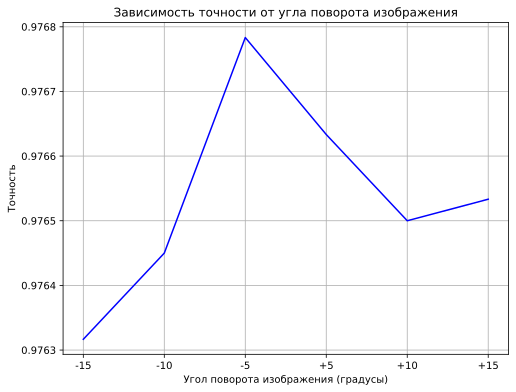

In [23]:
labels = list(scores.keys())
values = list(scores.values())
labels_numbers = [int(label) for label in labels]
sorted_indices = sorted(range(len(labels_numbers)), key=lambda k: labels_numbers[k])
sorted_labels = [labels[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]
plt.figure(figsize=(8, 6))
plt.plot(sorted_labels, sorted_values, color='blue')
plt.xlabel('Угол поворота изображения (градусы)')
plt.ylabel('Точность')
plt.title('Зависимость точности от угла поворота изображения')
plt.grid(True)
plt.savefig('rotation_metric.pdf', format='pdf')
plt.show()

Точность на тестовой выборке: 0.975100
Точность по кросс-валидации: 0.976467


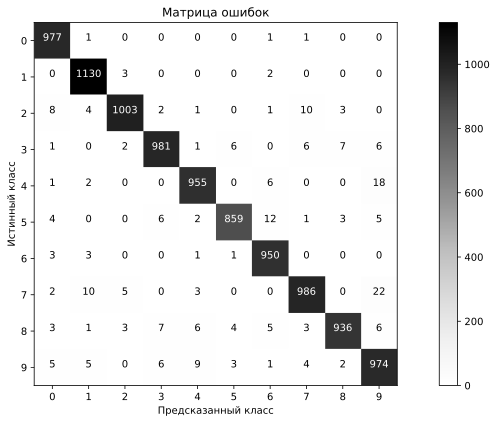

In [24]:
best_knn = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
best_knn.fit(X_rot_minus_5, y_train)
y_pred = best_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке: {test_accuracy:.6f}")
cv_accuracy = np.mean(knn_cross_val_score(X_rot_minus_5, y_train, k_list=[4], score='accuracy', cv=kfold(len(y_train), 3), metric='cosine', strategy='brute', weights=True)[4])
print(f"Точность по кросс-валидации: {cv_accuracy:.6f}")
print_condusion_matrix(y_test, y_pred, 'rot_plus_5')

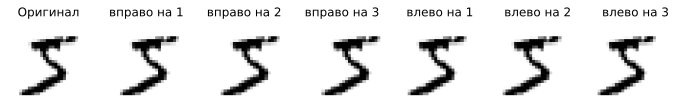

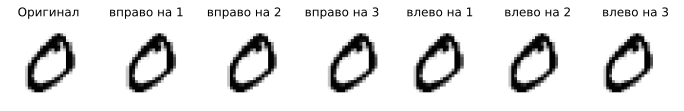

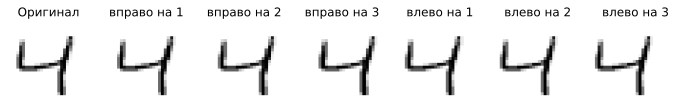

In [80]:
from scipy.ndimage import shift
i = 0
X_sh_x_plus_1 = []
X_sh_x_plus_2 = []
X_sh_x_plus_3 = []
X_sh_x_minus_1 = []
X_sh_x_minus_2 = []
X_sh_x_minus_3 = []
for row in X_train:
    image = row.reshape(28, 28).astype(np.uint8)
    shifted_image_p1 = shift(image, [0, 1], mode='constant', cval=0)
    shifted_image_p2 = shift(image, [0, 2], mode='constant', cval=0)
    shifted_image_p3 = shift(image, [0, 3], mode='constant', cval=0)
    shifted_image_m1 = shift(image, [0, -1], mode='constant', cval=0)
    shifted_image_m2 = shift(image, [0, -2], mode='constant', cval=0)
    shifted_image_m3 = shift(image, [0, -3], mode='constant', cval=0)
    X_sh_x_plus_1.append(np.array(shifted_image_p1).reshape(-1).astype(float))
    X_sh_x_plus_2.append(np.array(shifted_image_p2).reshape(-1).astype(float))
    X_sh_x_plus_3.append(np.array(shifted_image_p3).reshape(-1).astype(float))
    X_sh_x_minus_1.append(np.array(shifted_image_m1).reshape(-1).astype(float))
    X_sh_x_minus_2.append(np.array(shifted_image_m2).reshape(-1).astype(float))
    X_sh_x_minus_3.append(np.array(shifted_image_m3).reshape(-1).astype(float))
    if (i < 3):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 7, 1)
        plt.imshow(image, cmap='Greys')
        plt.title('Оригинал')
        plt.axis('off')
        plt.subplot(1, 7, 2)
        plt.imshow(shifted_image_p1, cmap='Greys')
        plt.title('вправо на 1')
        plt.axis('off')
        plt.subplot(1, 7, 3)
        plt.imshow(shifted_image_p2, cmap='Greys')
        plt.title('вправо на 2')
        plt.axis('off')
        plt.subplot(1, 7, 4)
        plt.imshow(shifted_image_p3, cmap='Greys')
        plt.title('вправо на 3')
        plt.axis('off')
        plt.subplot(1, 7, 5)
        plt.imshow(shifted_image_m1, cmap='Greys')
        plt.title('влево на 1')
        plt.axis('off')
        plt.subplot(1, 7, 6)
        plt.imshow(shifted_image_m2, cmap='Greys')
        plt.title('влево на 2')
        plt.axis('off')
        plt.subplot(1, 7, 7)
        plt.imshow(shifted_image_m3, cmap='Greys')
        plt.title('влево на 3')
        plt.axis('off')
        plt.savefig('shift_OX_exmpl_'+str(i)+'.pdf', format='pdf')
        plt.show()
    i += 1
X_sh_x_plus_1 = np.array(X_sh_x_plus_1)
X_sh_x_plus_2 = np.array(X_sh_x_plus_2)
X_sh_x_plus_3 = np.array(X_sh_x_plus_3)
X_sh_x_minus_1 = np.array(X_sh_x_minus_1)
X_sh_x_minus_2 = np.array(X_sh_x_minus_2)
X_sh_x_minus_3 = np.array(X_sh_x_minus_3)

In [81]:
scores = {}
cv = kfold(len(y_train), 5)
scores['+1'] = np.mean(knn_cross_val_score(X_sh_x_plus_1, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['+2'] = np.mean(knn_cross_val_score(X_sh_x_plus_2, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['+3'] = np.mean(knn_cross_val_score(X_sh_x_plus_3, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['-1'] = np.mean(knn_cross_val_score(X_sh_x_minus_1, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['-2'] = np.mean(knn_cross_val_score(X_sh_x_minus_2, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['-3'] = np.mean(knn_cross_val_score(X_sh_x_minus_3, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])

In [82]:
scores

{'+1': 0.9769333333333332,
 '+2': 0.9769666666666665,
 '+3': 0.9769333333333334,
 '-1': 0.9769333333333332,
 '-2': 0.9769333333333332,
 '-3': 0.9769166666666667}

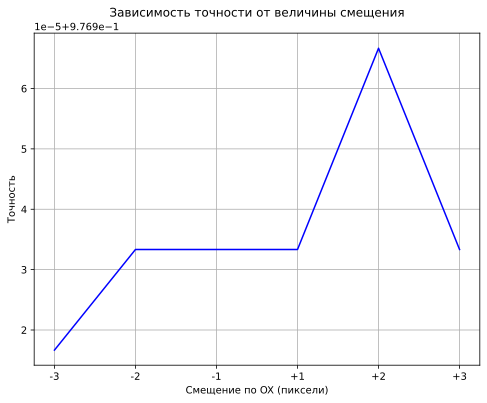

In [83]:
labels = list(scores.keys())
values = list(scores.values())
labels_numbers = [int(label) for label in labels]
sorted_indices = sorted(range(len(labels_numbers)), key=lambda k: labels_numbers[k])
sorted_labels = [labels[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]
plt.figure(figsize=(8, 6))
plt.plot(sorted_labels, sorted_values, color='blue')
plt.xlabel('Смещение по OX (пиксели)')
plt.ylabel('Точность')
plt.title('Зависимость точности от величины смещения')
plt.grid(True)
plt.savefig('shift_OX_metric.pdf', format='pdf')
plt.show()

In [85]:
#+2

Точность на тестовой выборке: 0.783200
Точность по кросс-валидации: 0.975300


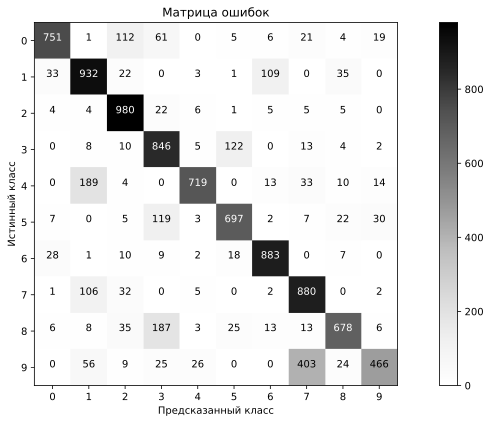

In [84]:
best_knn = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
best_knn.fit(X_sh_x_plus_2, y_train)
y_pred = best_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке: {test_accuracy:.6f}")
cv_accuracy = np.mean(knn_cross_val_score(X_sh_x_plus_2, y_train, k_list=[4], score='accuracy', cv=kfold(len(y_train), 3), metric='cosine', strategy='brute', weights=True)[4])
print(f"Точность по кросс-валидации: {cv_accuracy:.6f}")
print_condusion_matrix(y_test, y_pred, 'sh_x_plus_2')

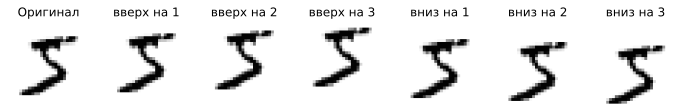

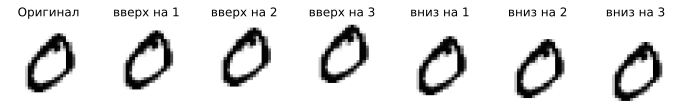

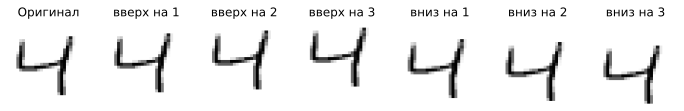

In [32]:
from scipy.ndimage import shift
i = 0
X_sh_y_plus_1 = []
X_sh_y_plus_2 = []
X_sh_y_plus_3 = []
X_sh_y_minus_1 = []
X_sh_y_minus_2 = []
X_sh_y_minus_3 = []
for row in X_train:
    image = row.reshape(28, 28).astype(np.uint8)
    shifted_image_p1 = shift(image, [-1, 0], mode='constant', cval=0)
    shifted_image_p2 = shift(image, [-2, 0], mode='constant', cval=0)
    shifted_image_p3 = shift(image, [-3, 0], mode='constant', cval=0)
    shifted_image_m1 = shift(image, [1, 0], mode='constant', cval=0)
    shifted_image_m2 = shift(image, [2, 0], mode='constant', cval=0)
    shifted_image_m3 = shift(image, [3, 0], mode='constant', cval=0)
    X_sh_y_plus_1.append(np.array(shifted_image_p1).reshape(-1).astype(float))
    X_sh_y_plus_2.append(np.array(shifted_image_p2).reshape(-1).astype(float))
    X_sh_y_plus_3.append(np.array(shifted_image_p3).reshape(-1).astype(float))
    X_sh_y_minus_1.append(np.array(shifted_image_m1).reshape(-1).astype(float))
    X_sh_y_minus_2.append(np.array(shifted_image_m2).reshape(-1).astype(float))
    X_sh_y_minus_3.append(np.array(shifted_image_m3).reshape(-1).astype(float))
    if (i < 3):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 7, 1)
        plt.imshow(image, cmap='Greys', extent=[0, 28, 0, 28])
        plt.title('Оригинал')
        plt.axis('off')
        plt.subplot(1, 7, 2)
        plt.imshow(shifted_image_p1, cmap='Greys')
        plt.title('вверх на 1')
        plt.axis('off')
        plt.subplot(1, 7, 3)
        plt.imshow(shifted_image_p2, cmap='Greys')
        plt.title('вверх на 2')
        plt.axis('off')
        plt.subplot(1, 7, 4)
        plt.imshow(shifted_image_p3, cmap='Greys')
        plt.title('вверх на 3')
        plt.axis('off')
        plt.subplot(1, 7, 5)
        plt.imshow(shifted_image_m1, cmap='Greys')
        plt.title('вниз на 1')
        plt.axis('off')
        plt.subplot(1, 7, 6)
        plt.imshow(shifted_image_m2, cmap='Greys')
        plt.title('вниз на 2')
        plt.axis('off')
        plt.subplot(1, 7, 7)
        plt.imshow(shifted_image_m3, cmap='Greys')
        plt.title('вниз на 3')
        plt.axis('off')
        plt.savefig('shift_OY_exmpl_'+str(i)+'.pdf', format='pdf')
        plt.show()
    i += 1
X_sh_y_plus_1 = np.array(X_sh_y_plus_1)
X_sh_y_plus_2 = np.array(X_sh_y_plus_2)
X_sh_y_plus_3 = np.array(X_sh_y_plus_3)
X_sh_y_minus_1 = np.array(X_sh_y_minus_1)
X_sh_y_minus_2 = np.array(X_sh_y_minus_2)
X_sh_y_minus_3 = np.array(X_sh_y_minus_3)

In [33]:
scores = {}
cv = kfold(len(y_train), 3)
scores['+1'] = np.mean(knn_cross_val_score(X_sh_y_plus_1, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['+2'] = np.mean(knn_cross_val_score(X_sh_y_plus_2, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['+3'] = np.mean(knn_cross_val_score(X_sh_y_plus_3, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['-1'] = np.mean(knn_cross_val_score(X_sh_y_minus_1, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['-2'] = np.mean(knn_cross_val_score(X_sh_y_minus_2, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['-3'] = np.mean(knn_cross_val_score(X_sh_y_minus_3, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])

In [34]:
scores

{'+1': 0.9751166666666666,
 '+2': 0.9751,
 '+3': 0.9750833333333334,
 '-1': 0.9751,
 '-2': 0.9750833333333334,
 '-3': 0.9749833333333333}

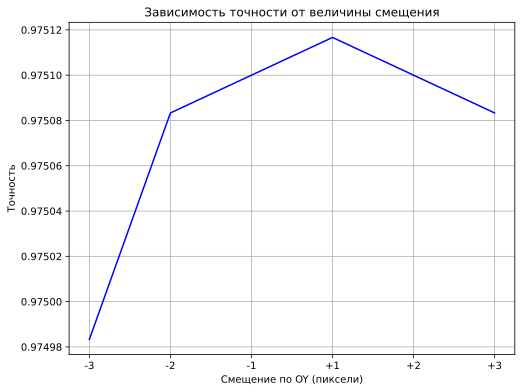

In [35]:
labels = list(scores.keys())
values = list(scores.values())
labels_numbers = [int(label) for label in labels]
sorted_indices = sorted(range(len(labels_numbers)), key=lambda k: labels_numbers[k])
sorted_labels = [labels[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]
plt.figure(figsize=(8, 6))
plt.plot(sorted_labels, sorted_values, color='blue')
plt.xlabel('Смещение по OY (пиксели)')
plt.ylabel('Точность')
plt.title('Зависимость точности от величины смещения')
plt.grid(True)
plt.savefig('shift_OY_metric.pdf', format='pdf')
plt.show()

Точность на тестовой выборке: 0.954800
Точность по кросс-валидации: 0.975550


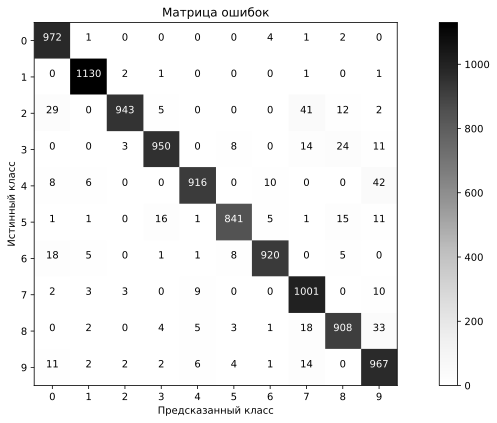

In [36]:
best_knn = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
best_knn.fit(X_sh_y_plus_1, y_train)
y_pred = best_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке: {test_accuracy:.6f}")
cv_accuracy = np.mean(knn_cross_val_score(X_sh_y_plus_1, y_train, k_list=[4], score='accuracy', cv=kfold(len(y_train), 3), metric='cosine', strategy='brute', weights=True)[4])
print(f"Точность по кросс-валидации: {cv_accuracy:.6f}")
print_condusion_matrix(y_test, y_pred, 'sh_y_minus_2')

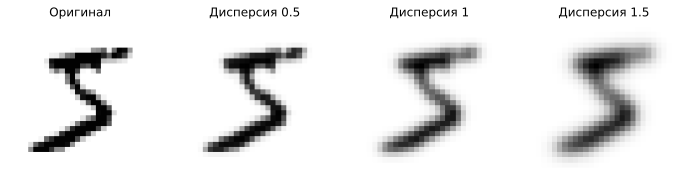

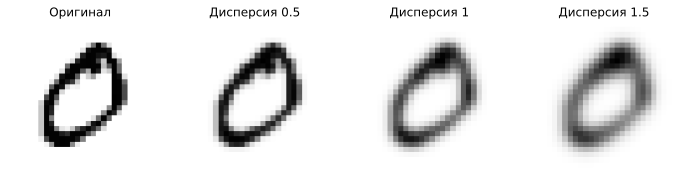

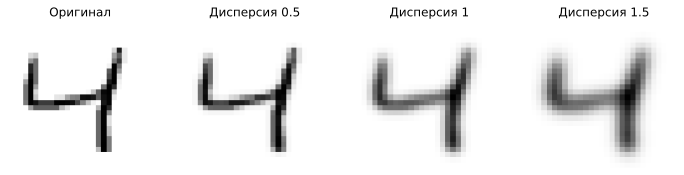

In [37]:
from scipy.ndimage import gaussian_filter
i = 0
X_gs_05 = []
X_gs_1 = []
X_gs_15 = []
for row in X_train:
    image = row.reshape(28, 28).astype(np.uint8)
    gs_image_1 = gaussian_filter(image, sigma=0.5)
    gs_image_2 = gaussian_filter(image, sigma=1.)
    gs_image_3 = gaussian_filter(image, sigma=1.5)
    X_gs_05.append(np.array(gs_image_1).reshape(-1).astype(float))
    X_gs_1.append(np.array(gs_image_2).reshape(-1).astype(float))
    X_gs_15.append(np.array(gs_image_3).reshape(-1).astype(float))
    if (i < 3):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(image, cmap='Greys')
        plt.title('Оригинал')
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(gs_image_1, cmap='Greys')
        plt.title('Дисперсия 0.5')
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.imshow(gs_image_2, cmap='Greys')
        plt.title('Дисперсия 1')
        plt.axis('off')
        plt.subplot(1, 4, 4)
        plt.imshow(gs_image_3, cmap='Greys')
        plt.title('Дисперсия 1.5')
        plt.axis('off')
        plt.savefig('gs_exmpl_'+str(i)+'.pdf', format='pdf')
        plt.show()
    i += 1
X_gs_05 = np.array(X_gs_05)
X_gs_1= np.array(X_gs_1)
X_gs_15 = np.array(X_gs_15)

In [38]:
scores = {}
cv = kfold(len(y_train), 3)
scores['0.5'] = np.mean(knn_cross_val_score(X_gs_05, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['1'] = np.mean(knn_cross_val_score(X_gs_1, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['1.5'] = np.mean(knn_cross_val_score(X_gs_15, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])

In [39]:
scores

{'0.5': 0.9769666666666668, '1': 0.9788333333333332, '1.5': 0.9753666666666666}

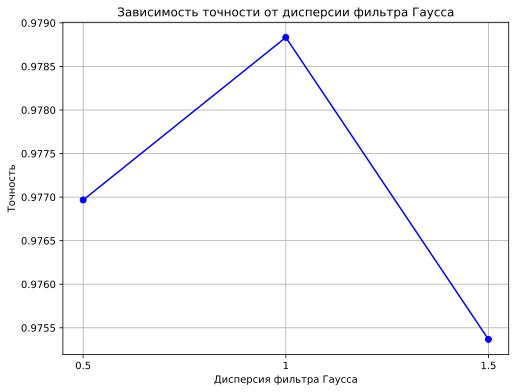

In [40]:
labels = list(scores.keys())
values = list(scores.values())
labels_numbers = [float(label) for label in labels]
sorted_indices = sorted(range(len(labels_numbers)), key=lambda k: labels_numbers[k])
sorted_labels = [labels[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]
plt.figure(figsize=(8, 6))
plt.plot(sorted_labels, sorted_values, color='blue', marker='o')
plt.xlabel('Дисперсия фильтра Гаусса')
plt.ylabel('Точность')
plt.title('Зависимость точности от дисперсии фильтра Гаусса')
plt.grid(True)
plt.savefig('gs_metric.pdf', format='pdf')
plt.show()

In [41]:
#1

Точность на тестовой выборке: 0.981900
Точность по кросс-валидации: 0.978717


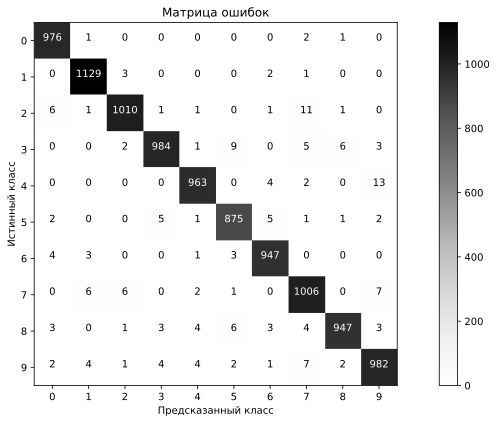

In [42]:
best_knn = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
best_knn.fit(X_gs_1, y_train)
y_pred = best_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке: {test_accuracy:.6f}")
cv_accuracy = np.mean(knn_cross_val_score(X_gs_1, y_train, k_list=[4], score='accuracy', cv=kfold(len(y_train), 3), metric='cosine', strategy='brute', weights=True)[4])
print(f"Точность по кросс-валидации: {cv_accuracy:.6f}")
print_condusion_matrix(y_test, y_pred, 'gs_1')

In [43]:
! pip install opencv-python

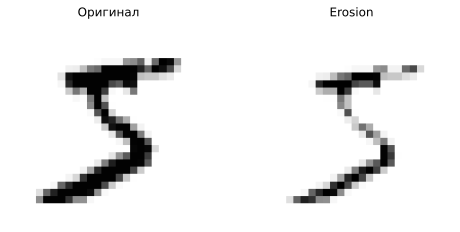

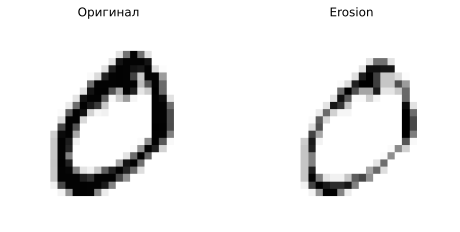

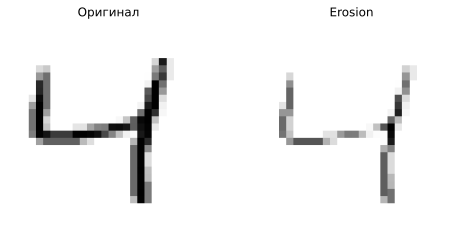

In [44]:
import cv2
kernel = np.ones((2,2), np.uint8)
i = 0
X_eroded = []
for row in X_train:
    image = row.reshape(28, 28).astype(np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=1)
    X_eroded.append(np.array(eroded_image).reshape(-1).astype(float))
    if (i < 3):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='Greys')
        plt.title('Оригинал')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(eroded_image, cmap='Greys')
        plt.title('Erosion')
        plt.savefig('erosion_exmpl_'+str(i)+'.pdf', format='pdf')
        plt.axis('off')
    i += 1
X_eroded = np.array(X_eroded)

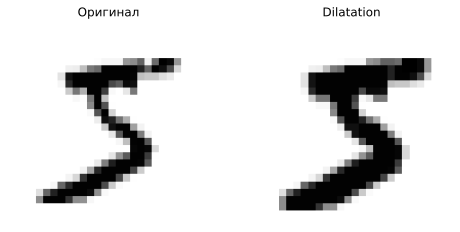

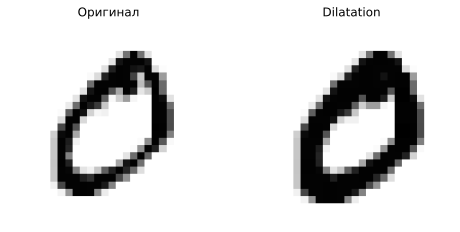

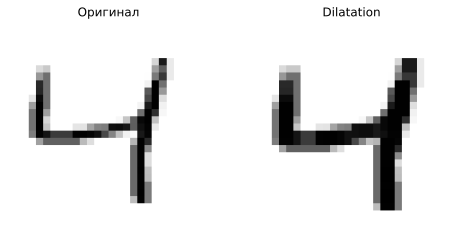

In [45]:
i = 0
X_dilatated = []
for row in X_train:
    image = row.reshape(28, 28).astype(np.uint8)
    dilatated_image = cv2.dilate(image, kernel, iterations=1)
    X_dilatated.append(np.array(dilatated_image).reshape(-1).astype(float))
    if (i < 3):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='Greys')
        plt.title('Оригинал')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(dilatated_image, cmap='Greys')
        plt.title('Dilatation')
        plt.axis('off')
        plt.savefig('dilatation_exmpl_'+str(i)+'.pdf', format='pdf')
        plt.show()
    i += 1
X_dilatated = np.array(X_dilatated)

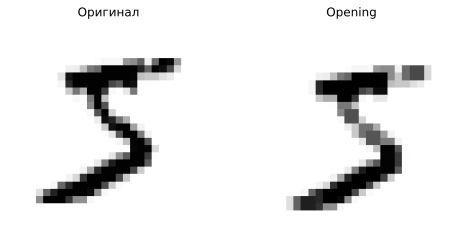

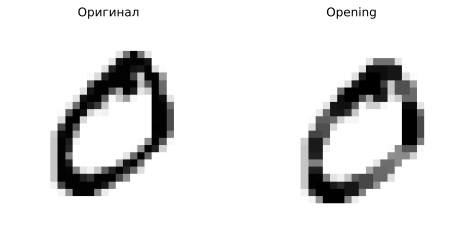

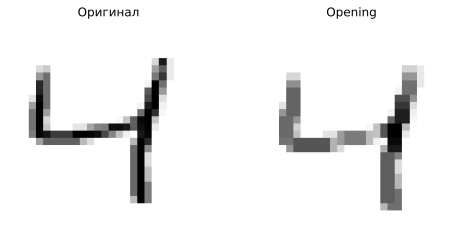

In [46]:
i = 0
X_opened = []
for row in X_train:
    image = row.reshape(28, 28).astype(np.uint8)
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    X_opened.append(np.array(opened_image).reshape(-1).astype(float))
    if (i < 3):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='Greys')
        plt.title('Оригинал')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(opened_image, cmap='Greys')
        plt.title('Opening')
        plt.axis('off')
        plt.savefig('opening_exmpl_'+str(i)+'.pdf', format='pdf')
        plt.show()
    i += 1
X_opened = np.array(X_opened)

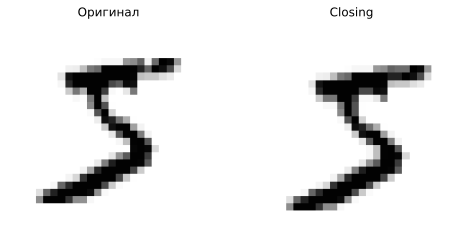

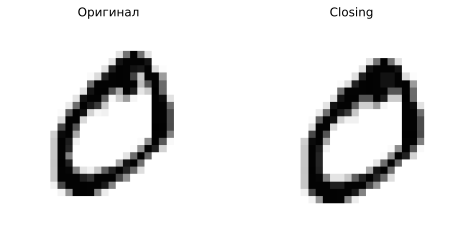

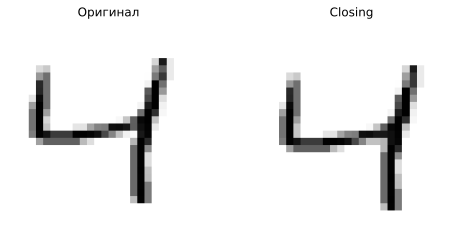

In [47]:
i = 0
X_closed = []
for row in X_train:
    image = row.reshape(28, 28).astype(np.uint8)
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    X_closed.append(np.array(closed_image).reshape(-1).astype(float))
    if (i < 3):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='Greys')
        plt.title('Оригинал')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(closed_image, cmap='Greys')
        plt.title('Closing')
        plt.axis('off')
        plt.savefig('closing_exmpl_'+str(i)+'.pdf', format='pdf')
        plt.show()
    i += 1
X_closed = np.array(X_closed)

In [48]:
scores = {}
cv = kfold(len(y_train), 3)
scores['erosion'] = np.mean(knn_cross_val_score(X_eroded, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['dilatation'] = np.mean(knn_cross_val_score(X_dilatated, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['opening'] = np.mean(knn_cross_val_score(X_opened, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])
scores['closing'] = np.mean(knn_cross_val_score(X_closed, y_train, k_list=[4], score='accuracy', cv=cv, metric='cosine', strategy='brute', weights=True)[4])

In [49]:
scores

{'erosion': 0.9573666666666667,
 'dilatation': 0.97315,
 'opening': 0.9724,
 'closing': 0.9746666666666667}

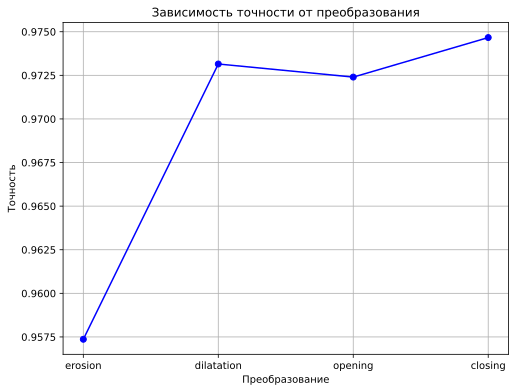

In [50]:
labels = list(scores.keys())
values = list(scores.values())
plt.figure(figsize=(8, 6))
plt.plot(labels, values, color='blue', marker='o')
plt.xlabel('Преобразование')
plt.ylabel('Точность')
plt.title('Зависимость точности от преобразования')
plt.grid(True)
plt.savefig('metamorphosis_metric.pdf', format='pdf')
plt.show()

In [51]:
#closing

Точность на тестовой выборке: 0.895000
Точность по кросс-валидации: 0.973350


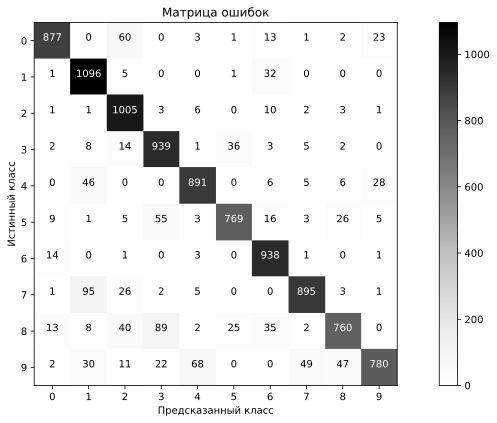

In [52]:
best_knn = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
best_knn.fit(X_closed, y_train)
y_pred = best_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке: {test_accuracy:.6f}")
cv_accuracy = np.mean(knn_cross_val_score(X_closed, y_train, k_list=[4], score='accuracy', cv=kfold(len(y_train), 3), metric='cosine', strategy='brute', weights=True)[4])
print(f"Точность по кросс-валидации: {cv_accuracy:.6f}")
print_condusion_matrix(y_test, y_pred, 'closed')

In [53]:
#X_closed, X_gs_1, X_rot_minus_5, X_sh_x_plus_2, X_sh_y_plus_1

In [86]:
X_train_new = np.vstack((X_train, X_sh_x_plus_2, X_sh_y_plus_1, X_closed, X_gs_1, X_rot_minus_5))
y_train_new = np.hstack((y_train, y_train, y_train, y_train, y_train, y_train))

In [87]:
X_train_new.shape

(360000, 784)

In [88]:
y_train_new.shape

(360000,)

Точность на тестовой выборке: 0.983100


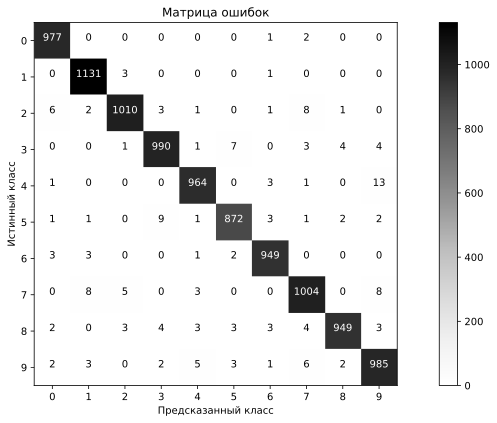

In [89]:
best_knn = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
best_knn.fit(X_train_new, y_train_new)
y_pred = best_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке: {test_accuracy:.6f}")
print_condusion_matrix(y_test, y_pred, 'train_new')

In [90]:
X_test_rot_plus_5 = []
X_test_rot_plus_10 = []
X_test_rot_plus_15 = []
X_test_rot_minus_5 = []
X_test_rot_minus_10 = []
X_test_rot_minus_15 = []
for row in X_test:
    image = row.reshape(28, 28).astype(np.uint8)
    rotated_image_p5 = rotate(image, angle=5, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    rotated_image_p10 = rotate(image, angle=10, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    rotated_image_p15 = rotate(image, angle=15, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    rotated_image_m5 = rotate(image, angle=-5, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    rotated_image_m10 = rotate(image, angle=-10, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    rotated_image_m15 = rotate(image, angle=-15, reshape=False, order=3, mode='constant', cval=0.0, prefilter=True)
    X_test_rot_plus_5.append(np.array(rotated_image_p5).reshape(-1).astype(float))
    X_test_rot_plus_10.append(np.array(rotated_image_p10).reshape(-1).astype(float))
    X_test_rot_plus_15.append(np.array(rotated_image_p15).reshape(-1).astype(float))
    X_test_rot_minus_5.append(np.array(rotated_image_m5).reshape(-1).astype(float))
    X_test_rot_minus_10.append(np.array(rotated_image_m10).reshape(-1).astype(float))
    X_test_rot_minus_15.append(np.array(rotated_image_m15).reshape(-1).astype(float))
X_test_rot_plus_5 = np.array(X_test_rot_plus_5)
X_test_rot_plus_10 = np.array(X_test_rot_plus_10)
X_test_rot_plus_15 = np.array(X_test_rot_plus_15)
X_test_rot_minus_5 = np.array(X_test_rot_minus_5)
X_test_rot_minus_10 = np.array(X_test_rot_minus_10)
X_test_rot_minus_15 = np.array(X_test_rot_minus_15)

X_test_sh_X_test_plus_1 = []
X_test_sh_X_test_plus_2 = []
X_test_sh_X_test_plus_3 = []
X_test_sh_X_test_minus_1 = []
X_test_sh_X_test_minus_2 = []
X_test_sh_X_test_minus_3 = []
for row in X_test:
    image = row.reshape(28, 28).astype(np.uint8)
    shifted_image_p1 = shift(image, [0, 1], mode='constant', cval=0)
    shifted_image_p2 = shift(image, [0, 2], mode='constant', cval=0)
    shifted_image_p3 = shift(image, [0, 3], mode='constant', cval=0)
    shifted_image_m1 = shift(image, [0, -1], mode='constant', cval=0)
    shifted_image_m2 = shift(image, [0, -2], mode='constant', cval=0)
    shifted_image_m3 = shift(image, [0, -3], mode='constant', cval=0)
    X_test_sh_X_test_plus_1.append(np.array(shifted_image_p1).reshape(-1).astype(float))
    X_test_sh_X_test_plus_2.append(np.array(shifted_image_p2).reshape(-1).astype(float))
    X_test_sh_X_test_plus_3.append(np.array(shifted_image_p3).reshape(-1).astype(float))
    X_test_sh_X_test_minus_1.append(np.array(shifted_image_m1).reshape(-1).astype(float))
    X_test_sh_X_test_minus_2.append(np.array(shifted_image_m2).reshape(-1).astype(float))
    X_test_sh_X_test_minus_3.append(np.array(shifted_image_m3).reshape(-1).astype(float))
X_test_sh_X_test_plus_1 = np.array(X_test_sh_X_test_plus_1)
X_test_sh_X_test_plus_2 = np.array(X_test_sh_X_test_plus_2)
X_test_sh_X_test_plus_3 = np.array(X_test_sh_X_test_plus_3)
X_test_sh_X_test_minus_1 = np.array(X_test_sh_X_test_minus_1)
X_test_sh_X_test_minus_2 = np.array(X_test_sh_X_test_minus_2)
X_test_sh_X_test_minus_3 = np.array(X_test_sh_X_test_minus_3)

X_test_sh_y_plus_1 = []
X_test_sh_y_plus_2 = []
X_test_sh_y_plus_3 = []
X_test_sh_y_minus_1 = []
X_test_sh_y_minus_2 = []
X_test_sh_y_minus_3 = []
for row in X_test:
    image = row.reshape(28, 28).astype(np.uint8)
    shifted_image_p1 = shift(image, [-1, 0], mode='constant', cval=0)
    shifted_image_p2 = shift(image, [-2, 0], mode='constant', cval=0)
    shifted_image_p3 = shift(image, [-3, 0], mode='constant', cval=0)
    shifted_image_m1 = shift(image, [1, 0], mode='constant', cval=0)
    shifted_image_m2 = shift(image, [2, 0], mode='constant', cval=0)
    shifted_image_m3 = shift(image, [3, 0], mode='constant', cval=0)
    X_test_sh_y_plus_1.append(np.array(shifted_image_p1).reshape(-1).astype(float))
    X_test_sh_y_plus_2.append(np.array(shifted_image_p2).reshape(-1).astype(float))
    X_test_sh_y_plus_3.append(np.array(shifted_image_p3).reshape(-1).astype(float))
    X_test_sh_y_minus_1.append(np.array(shifted_image_m1).reshape(-1).astype(float))
    X_test_sh_y_minus_2.append(np.array(shifted_image_m2).reshape(-1).astype(float))
    X_test_sh_y_minus_3.append(np.array(shifted_image_m3).reshape(-1).astype(float))
X_test_sh_y_plus_1 = np.array(X_test_sh_y_plus_1)
X_test_sh_y_plus_2 = np.array(X_test_sh_y_plus_2)
X_test_sh_y_plus_3 = np.array(X_test_sh_y_plus_3)
X_test_sh_y_minus_1 = np.array(X_test_sh_y_minus_1)
X_test_sh_y_minus_2 = np.array(X_test_sh_y_minus_2)
X_test_sh_y_minus_3 = np.array(X_test_sh_y_minus_3)

X_test_gs_05 = []
X_test_gs_1 = []
X_test_gs_15 = []
for row in X_test:
    image = row.reshape(28, 28).astype(np.uint8)
    gs_image_1 = gaussian_filter(image, sigma=0.5)
    gs_image_2 = gaussian_filter(image, sigma=1.)
    gs_image_3 = gaussian_filter(image, sigma=1.5)
    X_test_gs_05.append(np.array(gs_image_1).reshape(-1).astype(float))
    X_test_gs_1.append(np.array(gs_image_2).reshape(-1).astype(float))
    X_test_gs_15.append(np.array(gs_image_3).reshape(-1).astype(float))
X_test_gs_05 = np.array(X_test_gs_05)
X_test_gs_1= np.array(X_test_gs_1)
X_test_gs_15 = np.array(X_test_gs_15)

kernel = np.ones((2,2), np.uint8)

X_test_eroded = []
for row in X_test:
    image = row.reshape(28, 28).astype(np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=1)
    X_test_eroded.append(np.array(eroded_image).reshape(-1).astype(float))
X_test_eroded = np.array(X_test_eroded)

X_test_dilatated = []
for row in X_test:
    image = row.reshape(28, 28).astype(np.uint8)
    dilatated_image = cv2.dilate(image, kernel, iterations=1)
    X_test_dilatated.append(np.array(dilatated_image).reshape(-1).astype(float))
X_test_dilatated = np.array(X_test_dilatated)

X_test_opened = []
for row in X_test:
    image = row.reshape(28, 28).astype(np.uint8)
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    X_test_opened.append(np.array(opened_image).reshape(-1).astype(float))
X_test_opened = np.array(X_test_opened)

X_test_closed = []
for row in X_test:
    image = row.reshape(28, 28).astype(np.uint8)
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    X_test_closed.append(np.array(closed_image).reshape(-1).astype(float))
X_test_closed = np.array(X_test_closed)

In [91]:
X_test_new = np.vstack((X_test_rot_plus_5,
                          X_test_rot_plus_10,
                          X_test_rot_plus_15,
                          X_test_rot_minus_5,
                          X_test_rot_minus_10,
                          X_test_rot_minus_15,
                          X_test_sh_y_plus_1,
                          X_test_sh_y_plus_2,
                          X_test_sh_y_plus_3,
                          X_test_sh_y_minus_1,
                          X_test_sh_y_minus_2,
                          X_test_sh_y_minus_3,
                          X_test_gs_05,
                          X_test_gs_1,
                          X_test_gs_15,
                          X_test_eroded,
                          X_test_dilatated,
                          X_test_opened,
                          X_test_closed))
y_test_new = np.hstack((y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test,
                        y_test))

In [92]:
X_test_new.shape

(190000, 784)

In [93]:
y_test_new.shape

(190000,)

Точность на тестовой выборке: 0.891442


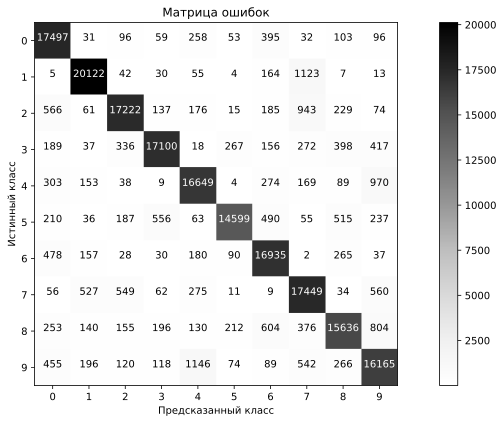

In [94]:
best_knn = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test_new)
test_accuracy = accuracy_score(y_test_new, y_pred)
print(f"Точность на тестовой выборке: {test_accuracy:.6f}")
print_condusion_matrix(y_test_new, y_pred, 'test_new')